## Data Mining - MSDS 7331 - Thurs 6:30, Summer 2016
Team 3: Sal Melendez, Rahn Lieberman, Thomas Rogers

Github page: https://github.com/RahnL/DataScience-SMU/tree/master/DataMining

### Overview

Our team chose to pursue collaborative filtering to build a custom recommendation system (Option C), using Amazon Instant Video recommendation data (http://jmcauley.ucsd.edu/data/amazon/).

#### Business Understanding

In the world of digital commerce, engagement equates to revenue and personalization ensures “stickiness”. Amazon understood these concepts before most and leveraged data science to enable mass personalization on a scale not previously possible through their recommender system. The distinction between mass marketing and personalized marketing is best measured by effectiveness. Mass marketing feels intrusive and often consists of tactics that are “pushed” to potential consumers. The flipside of the push is a “pull” which is a similarly motivated message, but through personalization almost feels helpful.

An effective and scalable recommendation system is a competitive differentiator in many different markets. Consider that at its core, Amazon is a fairly simple marketplace with buyers and sellers. What makes Amazon powerful, beyond the breadth of offerings available, is that it brings insight to both sides of the buying and selling equation, with its recommendation system. 

Understanding the importance of recommender systems in digital commerce requires a bit of context. It may be that an algorithm exists to perfectly recommend a product to a person at the right place at the right time, but without elements like an effective user interface or without consideration for the user experience, that recommendation never makes it to the site visitor. 

#### Data Understanding

The data for this effort is taken from product reviews and metadata from Amazon, including 142.8 million reviews spanning from May of 1996 to July of 2014. Our analysis focuses specifically on Amazon Instant Video reviews and contains the following variables of the following types:
- asin – this is a unique variable defined by Amazon as, “A 10-character alphanumeric unique identifier assigned by Amazon.com and its partners for product identification within the Amazon organization.”
- helpful – this is a 1 x 2 matrix of numeric values, indicating whether the review was found helpful by a person viewing it. For example, [3 12] indicates 3 out of 12 people found it helpful.
- overall – this numeric value scales from 1 to 5 in whole increments.
- reviewText – this alpha-numeric value consists of free-form text from users writing whatever they think may be helpful as a narrative review.
- reviewTime – this variable consists of MM DD, YYYY and represents the date the review was made
- reviewerID – this unique identifier is a 14-character alpha-numeric used to identify the person providing the review
- reviewerName – this alphanumeric variable is user-defined and is the name that appears as the reviewer in the web application
- summary – this alphanumeric text represents a sample of the reviewText variable
- unixReviewTime – this ten-digit variable represents the time a review was given, in a standard format

### Data Preparation and Initialization

Below we set everything up by importing the data and looking at the first few records to validate what we expect to see in it.
Instead of pulling the dataset from the web, we have a local copy of it.

In [1]:
import graphlab as gl
import pandas
# set canvas to show sframes and sgraphs in ipython notebook
gl.canvas.set_target('ipynb')
import matplotlib.pyplot as plt
%matplotlib inline


# some Global settings
# so we are standard across any recommenders that we build.

# specify how many users to look up, so we don't need to look up everyone.
# This is the number k, in the documentation.
number_users = 5

# specify how many reviews to consider.
number_reviews = 10

In [20]:
# Load the data.  It's already been downloaded from the site listed above
# amazonfile = 'C:/Users/trogers/Documents/GitHub/DataScience-SMU/DataMining/data/Amazon_Instant_Video_5.json'
amazonfile = './data/Amazon_Instant_Video_5.json'
sf = gl.SFrame.read_json(amazonfile,orient='lines')


Finished parsing file C:\Users\rahnl\OneDrive\Documents\GitHub\DataScience-SMU\DataMining\data\Amazon_Instant_Video_5.json

Parsing completed. Parsed 100 lines in 0.362596 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[dict]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file C:\Users\rahnl\OneDrive\Documents\GitHub\DataScience-SMU\DataMining\data\Amazon_Instant_Video_5.json

Parsing completed. Parsed 37126 lines in 0.500589 secs.

In [24]:
# Look at first several records
sf.head(number_users)

Columns:
	asin	str
	helpful	list
	overall	float
	reviewText	str
	reviewTime	str
	reviewerID	str
	reviewerName	str
	summary	str
	unixReviewTime	int

Rows: 5

Data:
+------------+---------+---------+-------------------------------+-------------+
|    asin    | helpful | overall |           reviewText          |  reviewTime |
+------------+---------+---------+-------------------------------+-------------+
| B000H00VBQ |  [0, 0] |   2.0   | I had big expectations bec... |  05 3, 2014 |
| B000H00VBQ |  [0, 0] |   5.0   | I highly recommend this se... |  09 3, 2012 |
| B000H00VBQ |  [0, 1] |   1.0   | This one is a real snoozer... | 10 16, 2013 |
| B000H00VBQ |  [0, 0] |   4.0   | Mysteries are interesting.... | 10 30, 2013 |
| B000H00VBQ |  [1, 1] |   5.0   | This show always is excell... | 02 11, 2009 |
+------------+---------+---------+-------------------------------+-------------+
+----------------+--------------------------------+
|   reviewerID   |          reviewerName          |
+----------------+--------------------------------+
| A11N155CW1UV02 |            AdrianaM            |
| A3BC8O2KCL29V2 |            Carol T             |
| A60D5HQFOTSOM  | Daniel Cooper "dancoopermedia" |
| A1RJPIGRSNX4PW |         J. Kaplan "JJ"         |
| A16XRPF40679KG |         Michael Dobey          |
+----------------+--------------------------------+
+--------------------------------+----------------+
|            summary             | unixReviewTime |
+--------------------------------+----------------+
|   A little bit boring for me   |   1399075200   |
|     Excellent Grown Up TV      |   1346630400   |
|     Way too boring for me      |   1381881600   |
|  Robson Green is mesmerizing   |   1383091200   |
| Robson green and great writing |   1234310400   |
+--------------------------------+----------------+
[5 rows x 9 columns]

---

The table above is showing the fields in the dataset.  The three primary variables we are interested in is the ASIN, rating, and reviewer.

The reviewer is the person who just watched a particular video, identified by the ASIN.  Based on the video, we want to recommend other videos (ASIN's) based on what other people have watchined who have also seen the just-viewed data, and have rated the other videos high.

We expect duplicate (ASIN, Overall) because the videos are watched by mutliple users, and they may give the same ratings to the movie.  The data should be unique for each reviewer (ASIN, Overall, ReviewerID), since a person won't rate a move multiple times.

#### Data Quality

The basic descriptive statistics below demonstrate that there are no missing values, duplicate data or outliers. The data is clean and nothing needs fixing. Interesting to note that the average overall rating is a 4.2, that seems high and raises a question, do people only rate movies if they enjoy them?

In [28]:
# Validate range of ratings
sf['overall'].min() , sf['overall'].max()

(1.0, 5.0)

In [3]:
sf['overall'].mean()

4.209529709637443

In [4]:
sf['overall'].std()

1.1185346025400438

### Data Visualization

This section does some visualization of the initital data, in order to explore it a bit, and see what we're working with from a different perspective.


In [5]:
# Reading the JSON file into pandas for analysis and visualization

import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.mpl_style = 'default'
with open(amazonfile, 'rb') as f:
    data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
data_df = pd.read_json(data_json_str)

C:\Users\rahnl\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [34]:
# Checking that all fields have vale.
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37126 entries, 0 to 37125
Data columns (total 9 columns):
asin              37126 non-null object
helpful           37126 non-null object
overall           37126 non-null int64
reviewText        37126 non-null object
reviewTime        37126 non-null object
reviewerID        37126 non-null object
reviewerName      36797 non-null object
summary           37126 non-null object
unixReviewTime    37126 non-null int64
dtypes: int64(2), object(7)
memory usage: 2.5+ MB


---

The graph below shows a histogram of the review ratings.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000015E35EF0>]], dtype=object)

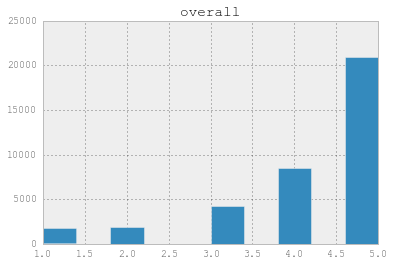

In [31]:
pd.options.display.mpl_style = 'default'

data_df.hist('overall')

---
The majority of them are rating a 5.0.  From our understanding of the business, the reason is because people tend to write reviews of things they have feelings about.  If a person is neutral about something, they're not going to spend time with a review.

The histogram also shows that the ratings are all between 1 and 5, to confirm we don't have strange data floating around.

Next, lets also look at the top reviewed videos


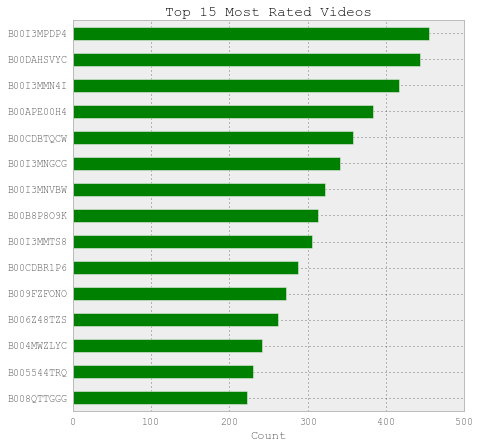

In [51]:
# Plot the top 15 most rated videos
plt.figure(figsize=(7,7))  # size is arbitrary, to make it fit on page.
data_df['asin'].value_counts()[:15].sort_values().plot(kind='barh',
                                                            title='Top 15 Most Rated Videos',
                                                            color='g',
                                                            grid=True)
plt.xlabel('Count')

In [53]:
# The ASIN's from the above graph, in descending order.
data_df['asin'].value_counts()[:15].sort_values(ascending=False)

# B00I3MPDP4 = Bosch, season 1.

B00I3MPDP4    455
B00DAHSVYC    444
B00I3MMN4I    417
B00APE00H4    384
B00CDBTQCW    358
B00I3MNGCG    341
B00I3MNVBW    322
B00B8P8O9K    313
B00I3MMTS8    306
B00CDBR1P6    288
B009FZFONO    273
B006Z48TZS    262
B004MWZLYC    242
B005544TRQ    230
B008QTTGGG    223
Name: asin, dtype: int64

In [35]:
# asingrouped = data_df.groupby('asin').mean()
# asingrouped.sort_values(by='overall',ascending=False)

#### Build the model

We randomly split our data into a training (80%) and test (20%) sets.

In [8]:
(train_set, test_set) = sf.random_split(0.8, seed=1)

First, we'll create a popularity model, which is based just off the ratings field in the file.  

This will be our baseline to look at, and in the business sense, it's randomly assigning recommendations bases on it being a highly rated item.  This may be what would be seen on a homepage if someone isn't logged in, so there's no context about what to show them. 

In [9]:
# remember "overall" is the rating field.

popularity_model = gl.popularity_recommender.create(train_set, user_id='reviewerID', item_id='asin',
                                                    target='overall', 
                                                    user_data=None, 
                                                    item_data=None,
                                                    random_seed=0,
                                                    verbose=True)

Recsys training: model = popularity

Warning: Ignoring columns helpful, reviewText, reviewTime, reviewerName, summary, unixReviewTime;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 29707 observations with 5130 users and 1685 items.

Data prepared in: 0.155286s

29707 observations to process; with 1685 unique items.

---
Using the popularity model, lets looks at the first few recommendations, and evaluate for ourselves if they look good. 

The popularity model is a good baseline recommender to use to compare against other recommenders, to see how they do against each other. This creates recommendations based on how often something is seen in the training set, and is good for sparse data or where a specific user may not be specified.


*** Note that you can look up ASIN's on Amazon using a special URL format, or typing it into the search button.  For this sample, we didn't create an account that would allow us to auto-look these up in code.  The look up is done by hand. *

In [29]:
popularity_model.recommend(users=range(1,number_users),k=5)

reviewerID,asin,score,rank
1,B001ATJQB4,5.0,1
1,B000VU2STU,5.0,2
1,B000ULZLYY,5.0,3
1,B000UERE3M,5.0,4
1,B000IKP5AM,5.0,5
2,B001ATJQB4,5.0,1
2,B000VU2STU,5.0,2
2,B000ULZLYY,5.0,3
2,B000UERE3M,5.0,4
2,B000IKP5AM,5.0,5


---
(Note this is what came up as top 5 for one run. Since there is some randomness to the ratings, this may change from run to run.)

1. https://www.amazon.com/exec/obidos/ASIN/B003336P1Y : Curious George (Season 3)
2. https://www.amazon.com/exec/obidos/ASIN/B00332YHLU : Curious George (Season 2)
3. https://www.amazon.com/exec/obidos/ASIN/B002T33I64 : Sesame Street (Season 36)
4. https://www.amazon.com/exec/obidos/ASIN/B001NJO76U : Dirty Jobs (Season 1)
5. https://www.amazon.com/exec/obidos/ASIN/B001I8O2MK : ER (Season 15)

For the first 3, these seem reasonable.  A kid watching a show would want to watch more of the same, or a another kids show.


Also, in order to evaluate this, lets try looking at recommendations for a specific video, say the most highly rated one from above.

In [66]:
recommendation_top1 = popularity_model.get_similar_items(items=['B00I3MPDP4'], k=5)
recommendation_top1

asin,similar,score,rank
B00I3MPDP4,B00JBNX59U,0.999999044975,1
B00I3MPDP4,B002SDOI14,0.999997552125,2
B00I3MPDP4,B001R68VPC,0.999995564132,3
B00I3MPDP4,B001CMQH5M,0.999995564132,4
B00I3MPDP4,B000MVI8HO,0.999995564132,5


---
##### Collaborative filtering

Next, lets create a collaborative filter.  This will make predictions based on other users activities, such as people who watch Curious George also watch Sesame Street.

For similarity type, we can chose between three type:
* **Jaccard:**  This is typically used in boolean decisions, not ratings.
* **Cosine:** 
* **Pearson:**



In [11]:
item_sim_model = gl.item_similarity_recommender.create(train_set, 
                                                       user_id='reviewerID', 
                                                       item_id='asin',
                                                       target='overall',
                                                       similarity_type='pearson'
                                                      )



Recsys training: model = item_similarity

Warning: Ignoring columns helpful, reviewText, reviewTime, reviewerName, summary, unixReviewTime;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 29707 observations with 5130 users and 1685 items.

Data prepared in: 0.073199s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 13.036ms                       | 58.25      |

| 24.065ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 67.684ms                            | 0                | 0               |

| 99.772ms                            | 100              | 1685            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.14041s

--- 
And again, a simple sanity check:


In [12]:
item_sim_model.recommend(users=range(1,number_users),k=number_reviews)


reviewerID,asin,score,rank
1,B003336P1Y,5.0,1
1,B00332YHLU,5.0,2
1,B002T33I64,5.0,3
1,B001NJO76U,5.0,4
1,B001I8O2MK,5.0,5
1,B001ATJQB4,5.0,6
1,B000VU2STU,5.0,7
1,B000ULZLYY,5.0,8
1,B000UERE3M,5.0,9
1,B000IKP5AM,5.0,10


---
1. https://www.amazon.com/exec/obidos/ASIN/B00I3MPDP4 : Bosch (Season 1)
2. https://www.amazon.com/exec/obidos/ASIN/B00I3MNGCG : Mozart in the Jungle (Season 1)
3. https://www.amazon.com/exec/obidos/ASIN/B00I3MMTS8 : Transparent (Season 1)
4. https://www.amazon.com/exec/obidos/ASIN/B00I3MNVBW : The Rebels (Season 1)
5. https://www.amazon.com/exec/obidos/ASIN/B00C6C96UK : Kill Zombies

While this is a bit of a random assortment, it seems like a reasonable set of things to recommend.  The first 4 are drama's, and the comedy movie.


Next, we will compare the two models to each other, and see how they do.

In [13]:
result = gl.recommender.util.compare_models(test_set, [popularity_model, item_sim_model],
                                            user_sample=.1, skip_set=train_set)

compare_models: using 388 users to estimate model performance
PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+-------------------+------------------+
| cutoff |   mean_precision  |   mean_recall    |
+--------+-------------------+------------------+
|   1    |  0.00257731958763 | 0.00128865979381 |
|   2    |  0.00128865979381 | 0.00128865979381 |
|   3    |  0.00085910652921 | 0.00128865979381 |
|   4    |  0.00128865979381 | 0.00257731958763 |
|   5    |  0.00103092783505 | 0.00257731958763 |
|   6    |  0.00085910652921 | 0.00257731958763 |
|   7    |  0.00110456553756 | 0.00343642611684 |
|   8    | 0.000966494845361 | 0.00343642611684 |
|   9    |  0.00085910652921 | 0.00343642611684 |
|   10   | 0.000773195876289 | 0.00343642611684 |
+--------+-------------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 1.059677560656642)

Per User RMSE (best)
+----------------+-------+------+
|   reviewerID   | count | rmse |
+-----

In [14]:

K = 10
users = gl.SArray(sf['reviewerID'].unique().head(100))

recs = item_sim_model.recommend(users=users, k=K)
recs.head()

reviewerID,asin,score,rank
A2PO6BB2VDMF1T,B003336P1Y,5.0,1
A2PO6BB2VDMF1T,B00332YHLU,5.0,2
A2PO6BB2VDMF1T,B002T33I64,5.0,3
A2PO6BB2VDMF1T,B001NJO76U,5.0,4
A2PO6BB2VDMF1T,B001I8O2MK,5.0,5
A2PO6BB2VDMF1T,B001ATJQB4,5.0,6
A2PO6BB2VDMF1T,B000VU2STU,5.0,7
A2PO6BB2VDMF1T,B000ULZLYY,5.0,8
A2PO6BB2VDMF1T,B000UERE3M,5.0,9
A2PO6BB2VDMF1T,B000IKP5AM,5.0,10


In [15]:
from IPython.display import display
from IPython.display import Image

gl.canvas.set_target('ipynb')

item_item = gl.recommender.item_similarity_recommender.create(train_set, 
                                  user_id="reviewerID", 
                                  item_id="asin", 
                                  target="overall",
                                  only_top_k=number_users,
                                  similarity_type="cosine")

rmse_results = item_item.evaluate(test_set)

Recsys training: model = item_similarity

Warning: Ignoring columns helpful, reviewText, reviewTime, reviewerName, summary, unixReviewTime;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 29707 observations with 5130 users and 1685 items.

Data prepared in: 0.064177s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 0us                            | 77.75      |

| 1.004ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 68.141ms                            | 0                | 0               |

| 101.228ms                           | 100              | 1685            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.164395s

recommendations finished on 1000/3880 queries. users per second: 76716.5

recommendations finished on 2000/3880 queries. users per second: 79789.4

recommendations finished on 3000/3880 queries. users per second: 64332.1


Precision and recall summary statistics by cutoff
+--------+-----------------+-----------------+
| cutoff |  mean_precision |   mean_recall   |
+--------+-----------------+-----------------+
|   1    |  0.137371134021 | 0.0873629363191 |
|   2    |  0.115850515464 |  0.140872907162 |
|   3    | 0.0955326460481 |  0.170744766402 |
|   4    | 0.0818298969072 |  0.194446165518 |
|   5    | 0.0713402061856 |  0.209951411275 |
|   6    | 0.0637457044674 |  0.223581136361 |
|   7    | 0.0578055964654 |  0.236031747033 |
|   8    | 0.0524806701031 |  0.244432377044 |
|   9    | 0.0484822451317 |  0.253082205757 |
|   10   | 0.0451288659794 |  0.261750590637 |
+--------+-----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 4.249237119980557)

Per User RMSE (best)
+----------------+-------+------------------+
|   reviewerID   | count |       rmse       |
+----------------+-------+------------------+
| A1HSNJH5EFKR30 |   1   | 0.00615993142128 |
+----------------+----

In [16]:
print rmse_results.viewkeys()
print rmse_results['rmse_by_item']

dict_keys(['rmse_by_user', 'precision_recall_overall', 'rmse_by_item', 'precision_recall_by_user', 'rmse_overall'])
+------------+-------+---------------+
|    asin    | count |      rmse     |
+------------+-------+---------------+
| B00H2E66H8 |   2   |      4.0      |
| B00F2C1RPS |   10  | 4.62601340249 |
| B002JJC6E8 |   1   |      2.0      |
| B00CB6SU5I |   3   | 3.02650053314 |
| B007ZU23GC |   1   |      4.0      |
| B001QDKK3W |   15  | 4.45024402385 |
| B0082JW05O |   1   |      2.0      |
| B0015TFUSC |   4   | 4.28364438539 |
| B007O2TG6Q |   4   | 4.18330013267 |
| B00EIQJH8I |   2   |      5.0      |
+------------+-------+---------------+
[1470 rows x 3 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


In [17]:

rmse_results['rmse_by_user']

reviewerID,count,rmse
A34D06JL7LC6MU,1,4.0
A2VQ08XUBNDU88,2,4.52769256907
A1A6ADR8JG12KQ,4,4.38662273144
AKL6E6FRY6CHB,1,5.0
A2WOH395IHGS0T,2,4.8094992798
A2K38LTTVICB2I,1,5.0
A2LNXVZ63VT91L,2,4.52769256907
A1X8IR1ZE3I77A,1,5.0
AZQJGDWARL3RR,1,1.0
ALI6HO0QLZZ8C,3,4.50293363449


#### Deployment


*** Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? • How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? • How would your deploy your model for interested parties?  • What other data should be collected?  • How often would the model need to be updated, etc.? *

One thing missing in our data is any personal information about the reviewers, and information about the videos, such as genre, producers, actors, etc.
This information would be helpful to make the recommendations more personal.  That is, if we knew someones age, we could target based on recommendations by others with a same age group.  If we know someone likes watching British cooking shows, we could use that as a basis.


For a full-scale deployment, we would need to add in the lookup to Amazon, so show the video names instead of having to look it up manually.

It would also be good to be able to identify the particular user/reviewer, and look up the recommendations for that person.  That, in-fact, would be the end result for a production system.  To go with this, a sentiment analisys of the review may show some insights into ways to categorize items differently.

####  References:
* https://github.com/turi-code/tutorials/blob/master/notebooks/recsys_rank_10K_song.ipynb
* https://github.com/turi-code/tutorials/blob/master/notebooks/five_line_recommender.ipynb

Dataset:

Image-based recommendations on styles and substitutes
J. McAuley, C. Targett, J. Shi, A. van den Hengel
SIGIR, 2015

Inferring networks of substitutable and complementary products
J. McAuley, R. Pandey, J. Leskovec
Knowledge Discovery and Data Mining, 2015

http://jmcauley.ucsd.edu/data/amazon/